# Libraries

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import xgboost as xgb

nltk.download('stopwords')
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\27366\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

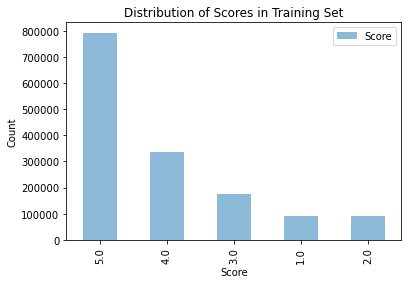


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [21]:

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('Distribution of Scores in Training Set')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [22]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

def add_features_to(df, score_averages):
    df = df.copy()  
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    df['Combined_Text'] = df['Summary'] + ' ' + df['Text']
    df['Combined_Text'] = df['Combined_Text'].apply(preprocess_text)
    df['Review_Length'] = df['Text'].apply(lambda x: len(x.split()))
    df['Word_Count'] = df['Combined_Text'].apply(lambda x: len(x.split()))
    df['Char_Count'] = df['Combined_Text'].apply(lambda x: len(x))
    df['Review_Year'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df = df.merge(score_averages['Product'], on='ProductId', how='left')
    df['Avg_Product_Score'] = df['Avg_Product_Score'].fillna(trainingSet['Score'].mean())
    df = df.merge(score_averages['User'], on='UserId', how='left')
    df['Avg_User_Score'] = df['Avg_User_Score'].fillna(trainingSet['Score'].mean())
    return df

def compute_score_averages(df):
    product_avg = df.groupby('ProductId')['Score'].mean().reset_index()
    product_avg.columns = ['ProductId', 'Avg_Product_Score']
    user_avg = df.groupby('UserId')['Score'].mean().reset_index()
    user_avg.columns = ['UserId', 'Avg_User_Score']
    return {'Product': product_avg, 'User': user_avg}

# Sample + Split into training and testing set

In [23]:
train_data = trainingSet[trainingSet['Score'].notnull()]
score_averages = compute_score_averages(train_data)
train = add_features_to(train_data, score_averages)

test = pd.merge(testingSet, trainingSet[['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
                                         'HelpfulnessDenominator', 'Summary', 'Text', 'Time']], on='Id', how='left')
test = add_features_to(test, score_averages)

X = train
Y = X['Score'].astype(int) - 1 

classes = np.unique(Y)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=Y)
class_weight_dict = dict(zip(classes, class_weights))

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)


# Feature Selection

In [24]:
numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness',
                    'Review_Length', 'Avg_Product_Score', 'Avg_User_Score',
                    'Word_Count', 'Char_Count', 'Review_Year']

tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 3),
                        sublinear_tf=True, max_df=0.95, min_df=2)
tfidf.fit(X_train['Combined_Text'])
X_train_tfidf = tfidf.transform(X_train['Combined_Text'])
X_val_tfidf = tfidf.transform(X_val['Combined_Text'])
X_test_tfidf = tfidf.transform(test['Combined_Text'])

chi2_selector = SelectKBest(chi2, k=5000)
X_train_tfidf = chi2_selector.fit_transform(X_train_tfidf, Y_train)
X_val_tfidf = chi2_selector.transform(X_val_tfidf)
X_test_tfidf = chi2_selector.transform(X_test_tfidf)

svd = TruncatedSVD(n_components=200, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

X_train_numeric = X_train[numeric_features].fillna(0)
X_val_numeric = X_val[numeric_features].fillna(0)
X_test_numeric = test[numeric_features].fillna(0)
scaler = MaxAbsScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_val_numeric_scaled = scaler.transform(X_val_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

X_train_combined = np.hstack((X_train_numeric_scaled, X_train_svd))
X_val_combined = np.hstack((X_val_numeric_scaled, X_val_svd))
X_test_combined = np.hstack((X_test_numeric_scaled, X_test_svd))

# Model Creation

In [25]:
nb_model = MultinomialNB()  
svm_model = LinearSVC(max_iter=10000, class_weight=class_weight_dict)
tree_model = DecisionTreeClassifier(max_depth=10, class_weight=class_weight_dict)
logreg_model = LogisticRegression(
    max_iter=5000,  
    class_weight=class_weight_dict,
    multi_class='multinomial',
    solver='saga', 
    n_jobs=-1
)
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=42
)
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1
)

meta_model = GradientBoostingClassifier(random_state=42) 

print("Training MultinomialNB...")
nb_model.fit(X_train_tfidf, Y_train)

print("Training LinearSVC...")
svm_model.fit(X_train_combined, Y_train)

print("Training DecisionTreeClassifier...")
tree_model.fit(X_train_combined, Y_train)

print("Training LogisticRegression...")
logreg_model.fit(X_train_combined, Y_train)

print("Training RandomForestClassifier...")
rf_model.fit(X_train_combined, Y_train)

print("Training XGBoost Classifier...")
xgb_model.fit(X_train_combined, Y_train)

print("Generating validation predictions...")
Y_val_nb_pred = nb_model.predict(X_val_tfidf).reshape(-1, 1)
Y_val_svm_pred = svm_model.predict(X_val_combined).reshape(-1, 1)
Y_val_tree_pred = tree_model.predict(X_val_combined).reshape(-1, 1)
Y_val_logreg_pred = logreg_model.predict(X_val_combined).reshape(-1, 1)
Y_val_rf_pred = rf_model.predict(X_val_combined).reshape(-1, 1)
Y_val_xgb_pred = xgb_model.predict(X_val_combined).reshape(-1, 1)

stacked_val_features = np.hstack((Y_val_nb_pred, Y_val_svm_pred, Y_val_tree_pred,
                                  Y_val_logreg_pred, Y_val_rf_pred, Y_val_xgb_pred))

print("Training meta-model...")
meta_model.fit(stacked_val_features, Y_val)

Training MultinomialNB...
Training LinearSVC...
Training DecisionTreeClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training XGBoost Classifier...
Generating validation predictions...
Training meta-model...


GradientBoostingClassifier(random_state=42)

# Model Evaluation

Final Stacked Model Accuracy on validation set =  0.6689826269317902
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.71      0.67     18238
           2       0.43      0.25      0.32     17936
           3       0.45      0.35      0.40     35216
           4       0.49      0.42      0.45     67046
           5       0.77      0.89      0.83    158633

    accuracy                           0.67    297069
   macro avg       0.56      0.52      0.53    297069
weighted avg       0.64      0.67      0.65    297069



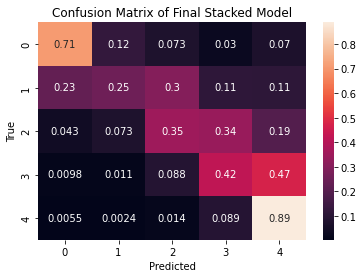

Generating test predictions...


In [26]:
Y_val_meta_pred = meta_model.predict(stacked_val_features) + 1  

accuracy = accuracy_score(Y_val + 1, Y_val_meta_pred)
print("Final Stacked Model Accuracy on validation set = ", accuracy)
print("Classification Report:")
print(classification_report(Y_val + 1, Y_val_meta_pred))

cm = confusion_matrix(Y_val + 1, Y_val_meta_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix of Final Stacked Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Generating test predictions...")
Y_test_nb_pred = nb_model.predict(X_test_tfidf).reshape(-1, 1)
Y_test_svm_pred = svm_model.predict(X_test_combined).reshape(-1, 1)
Y_test_tree_pred = tree_model.predict(X_test_combined).reshape(-1, 1)
Y_test_logreg_pred = logreg_model.predict(X_test_combined).reshape(-1, 1)
Y_test_rf_pred = rf_model.predict(X_test_combined).reshape(-1, 1)
Y_test_xgb_pred = xgb_model.predict(X_test_combined).reshape(-1, 1)

stacked_test_features = np.hstack((Y_test_nb_pred, Y_test_svm_pred, Y_test_tree_pred,
                                   Y_test_logreg_pred, Y_test_rf_pred, Y_test_xgb_pred))
Y_test_final_pred = meta_model.predict(stacked_test_features) + 1 


# Create submission file

In [27]:
submission = pd.DataFrame({
    'Id': test['Id'],
    'Score': Y_test_final_pred
})
submission.to_csv("./data/submission.csv", index=False)
print("Submission file created at './data/submission.csv'")

Submission file created at './data/submission.csv'
